<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li>
<span>
<a href="#section1" data-toc-modified-id="section1">
<span class="toc-item-num">1.&nbsp;&nbsp;</span>Executive Summary</a>
</span>
</li>    
<li>
<span>
<a href="#section2" data-toc-modified-id="section2">
<span class="toc-item-num">2.&nbsp;&nbsp;</span>Clustering</a>
</span>
</li>
<li>
<span>
<a href="#section3" data-toc-modified-id="section3">
<span class="toc-item-num">3.&nbsp;&nbsp;</span>Usage Segmentation</a>
</span>
<ul class="toc-item">
<li>
<span>
<a href="#section3_1" data-toc-modified-id="section3_1">
<span class="toc-item-num">3.1.&nbsp;&nbsp;</span>Monthly</a>
</span>
</li>
<li>
<span>
<a href="#section3_2" data-toc-modified-id="section3_2">
<span class="toc-item-num">3.2.&nbsp;&nbsp;</span>Weekday</a>
</span>
</li>
<li>
<span>
<a href="#section3_3" data-toc-modified-id="section3_3">
<span class="toc-item-num">3.3.&nbsp;&nbsp;</span>Hour</a>
</span>
</li>
<li>
<span>
<a href="#section3_4" data-toc-modified-id="section3_4">
<span class="toc-item-num">3.4.&nbsp;&nbsp;</span>Time</a>
</span>
</li>    
</ul>    
</li>    
<li>
<span>
<a href="#section4" data-toc-modified-id="section4">
<span class="toc-item-num">4.&nbsp;&nbsp;</span>Conclusions</a>
</span>    
</li>
</ul> 
</div>

<a id='section1'></a>

# Executive Summary

The data set being examined in this presentation has three data elements; Client, Time and Usage. Client and Time represent dimensions and Usage represents a fact table. This allows for examining data horizontally across clients and vertically across time.

The goal of this presentation will be to use clustering to segment clients into; low, medium and high usage clusters. In order to identify high profit clients and to gain greater understanding of the usage patterns of these high profit client segments.

Time segments will be examined across the following time aggregations; fifteen minute, hourly, weekdays, and months. A year over year comparison will also be provided.

In [246]:
import fileinput
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import warnings

import datetime
from datetime import date, timedelta, datetime
from itertools import compress
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

random.seed(42)

%matplotlib inline

warnings.filterwarnings('ignore')
sns.set()

In [247]:
class Electricity_Usage():
    
    clients = []
    
    file_data = ''
    file_name = ''
    
    average_curves_normalized = {}
    file_data_years = {}
    
    def load_file(self):
        
        time = []
        hour = []
        weekday = []
        month = []
        
        self.file_data = pd.read_csv(self.file_name, sep=';', index_col = 0)

        self.clients = self.file_data.columns
        
        for index, usage_data in self.file_data.iterrows():
    
            _datetime = datetime.strptime(index, '%Y-%m-%d %H:%M:%S')

            time.append(_datetime.time())
            hour.append(_datetime.hour)
            weekday.append(_datetime.weekday())
            month.append(_datetime.month)
            
        self.file_data['TIME'] = time
        self.file_data['HOUR'] = hour
        self.file_data['WEEKDAY'] = weekday
        self.file_data['MONTH'] = month
            
        self.file_data_years['2011'] = self.file_data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
        self.file_data_years['2012'] = self.file_data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
        self.file_data_years['2013'] = self.file_data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
        self.file_data_years['2014'] = self.file_data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']
        
    def get_inertia(self, electricity_usages, model):
    
        inertia = 0

        for electricity_usage in range(len(electricity_usages)):
            inertia = inertia + np.linalg.norm(electricity_usages[electricity_usage] - 
                                     model.cluster_centers_[model.labels_[electricity_usage]]) ** 2

        return inertia    
        
    def __init__(self):
        
        pass

In [248]:
_electricity_usage = Electricity_Usage()
_electricity_usage.file_name = 'LD2011_2014.txt'
_electricity_usage.load_file()

In [249]:
mean_usages = []

for time in set(_electricity_usage.file_data['MONTH']):
    
    time_df = _electricity_usage.file_data[_electricity_usage.file_data['MONTH'] == time]
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    
electricity_usages = normalize([mean_usages[0].values]).reshape(-1, 1)

Inertias = []
Silhouettes = []

for clusters in range(2, 4):
    model = KMeans(n_clusters = clusters, random_state = 0).fit(electricity_usages) 
    
    Inertias.append(_electricity_usage.get_inertia(electricity_usages, model))
    Silhouettes.append(silhouette_score(electricity_usages, model.labels_, metric = 'euclidean'))

# Clustering

<a id='section2'></a>

<AxesSubplot:>

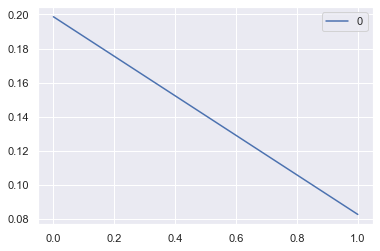

In [250]:
plot_df = pd.DataFrame(Inertias)
sns.lineplot(data = plot_df)

<AxesSubplot:>

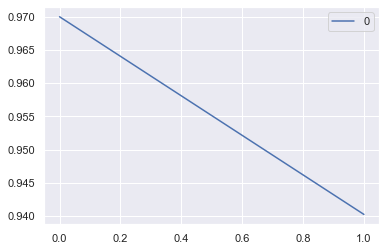

In [251]:
plot_df = pd.DataFrame(Silhouettes)
sns.lineplot(data = plot_df)

# Usage Segmentation

<a id='section3'></a>

## Monthly

<a id='section3_1'></a>

### All Years



In [252]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data['MONTH']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data[_electricity_usage.file_data['MONTH'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))
    
period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst
period_statistics['Usage Count Low'] = usage_count_low_lst
period_statistics['Usage Mean Low'] = usage_mean_low_lst
period_statistics['Usage Count Medium'] = usage_count_medium_lst
period_statistics['Usage Mean Medium'] = usage_mean_medium_lst
period_statistics['Usage Count High'] = usage_count_high_lst
period_statistics['Usage Mean High'] = usage_mean_high_lst

print('Medium Usage Clients (All Years)', set(usage_summary_medium_df['Client']))
print('High Usage Client (All Years)', set(usage_summary_high_df['Client']))

Medium Usage Clients (All Years) {'MT_279', 'MT_196', 'MT_228', 'MT_370', 'MT_208'}
High Usage Client (All Years) {'MT_362', 'MT_196'}


When examining electricity usage on a monthly basis across all years, five clients were identified as falling into the medium usage cluster (MT_196, MT_208, MT_228, MT_279, MT_370), and two clients were identified as falling into the high usuage cluster (MT_196, MT_362).

#### 2011

Medium Usage Clients (MT_220, MT_276, MT_279, MT_228, MT_208, MT_323, MT_191, MT_241, MT_194, MT_163, MT_216, MT_161)

High Usage Clients (MT_279, MT_196)

#### 2012

Medium Usage Clients (MT_279, MT_196)

High Usage Client (MT_362)

#### 2013

Medium Usage Clients (MT_370, MT_279, MT_196)

High Usage Client (MT_362)

#### 2014

Medium Usage Clients (MT_370, MT_279, MT_196)

High Usage Client (MT_362)

Medium usage clients appeared to have fairly consistent usage across all months. High usage clients appreared to have a clear increase in usage between the months of April and October.

In [253]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low,Usage Mean Low,Usage Count Medium,Usage Mean Medium,Usage Count High,Usage Mean High
0,1,364,0.007222,4,0.199700,2,0.607770
1,2,364,0.007478,4,0.205640,2,0.604676
2,3,364,0.007134,4,0.205557,2,0.604890
3,4,364,0.006729,4,0.204942,2,0.605222
4,5,366,0.006623,3,0.302876,1,0.780738
5,6,365,0.005727,4,0.236861,1,0.824247
6,7,365,0.005074,4,0.204648,1,0.868276
7,8,365,0.004852,4,0.197231,1,0.877689
8,9,364,0.005063,5,0.192364,1,0.856773
9,10,364,0.006012,5,0.224923,1,0.798674


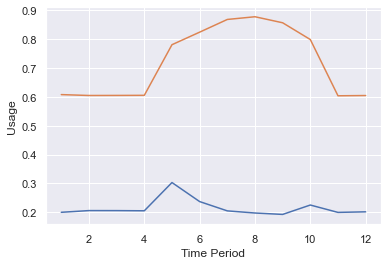

In [254]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2011

In [255]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2011']['MONTH']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2011'][_electricity_usage.file_data_years['2011']['MONTH'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2011'] = usage_count_low_lst
period_statistics['Usage Mean Low 2011'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2011'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2011'] = usage_mean_medium_lst
period_statistics['Usage Count High 2011'] = usage_count_high_lst
period_statistics['Usage Mean High 2011'] = usage_mean_high_lst

print('Medium Usage Clients (2011)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2011)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2011) {'MT_279', 'MT_163', 'MT_216', 'MT_228', 'MT_191', 'MT_276', 'MT_220', 'MT_194', 'MT_323', 'MT_161', 'MT_241', 'MT_208'}
High Usage Client (2011) {'MT_279', 'MT_196'}


In [256]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2011,Usage Mean Low 2011,Usage Count Medium 2011,Usage Mean Medium 2011,Usage Count High 2011,Usage Mean High 2011
0,1,357,0.004563,11,0.106104,2,0.614373
1,2,357,0.004644,11,0.108165,2,0.613859
2,3,357,0.004411,11,0.102670,2,0.618970
3,4,357,0.004383,11,0.105701,2,0.615161
4,5,366,0.006326,3,0.303090,1,0.772560
5,6,366,0.006290,3,0.290521,1,0.789205
6,7,366,0.006354,3,0.293623,1,0.786333
7,8,366,0.006288,3,0.287825,1,0.795302
8,9,366,0.006265,3,0.292302,1,0.789571
9,10,366,0.006274,3,0.298996,1,0.779967


In [257]:
year = [2011, 2012, 2013, 2014]
usage_mean_medium = []
usage_mean_high = []

usage_mean_medium.append(period_statistics['Usage Mean Medium 2011'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2011'].mean())

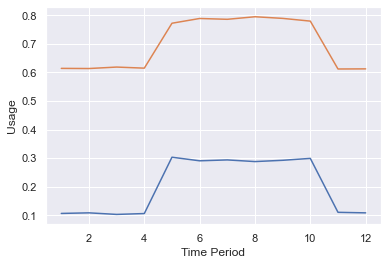

In [258]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2011', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2011', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2012

In [259]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2012']['MONTH']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2012'][_electricity_usage.file_data_years['2012']['MONTH'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2012'] = usage_count_low_lst
period_statistics['Usage Mean Low 2012'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2012'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2012'] = usage_mean_medium_lst
period_statistics['Usage Count High 2012'] = usage_count_high_lst
period_statistics['Usage Mean High 2012'] = usage_mean_high_lst

print('Medium Usage Clients (2012)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2012)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2012) {'MT_279', 'MT_196'}
High Usage Client (2012) {'MT_362'}


In [260]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2012,Usage Mean Low 2012,Usage Count Medium 2012,Usage Mean Medium 2012,Usage Count High 2012,Usage Mean High 2012
0,1,367,0.007345,2,0.346920,1,0.804162
1,2,367,0.007426,2,0.355079,1,0.794598
2,3,367,0.007026,2,0.345235,1,0.810388
3,4,367,0.006805,2,0.328514,1,0.826281
4,5,367,0.005420,2,0.265449,1,0.889472
5,6,367,0.004879,2,0.232078,1,0.913623
6,7,367,0.004271,2,0.207169,1,0.931990
7,8,367,0.004086,2,0.200937,1,0.936887
8,9,367,0.004664,2,0.224931,1,0.920240
9,10,367,0.006016,2,0.286812,1,0.868717


In [261]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2012'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2012'].mean())

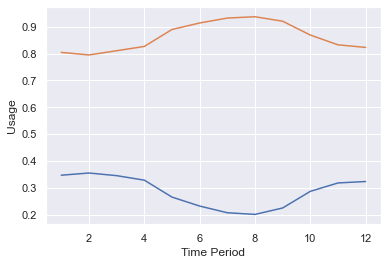

In [262]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2012', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2012', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2013

In [263]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2013']['MONTH']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2013'][_electricity_usage.file_data_years['2013']['MONTH'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2013'] = usage_count_low_lst
period_statistics['Usage Mean Low 2013'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2013'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2013'] = usage_mean_medium_lst
period_statistics['Usage Count High 2013'] = usage_count_high_lst
period_statistics['Usage Mean High 2013'] = usage_mean_high_lst

print('Medium Usage Clients (2013)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2013)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2013) {'MT_279', 'MT_196', 'MT_370'}
High Usage Client (2013) {'MT_362'}


In [264]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2013,Usage Mean Low 2013,Usage Count Medium 2013,Usage Mean Medium 2013,Usage Count High 2013,Usage Mean High 2013
0,1,366,0.007304,3,0.319080,1,0.767021
1,2,366,0.007860,3,0.337195,1,0.730572
2,3,366,0.007432,3,0.334382,1,0.744122
3,4,366,0.006714,3,0.325056,1,0.766132
4,5,366,0.005802,3,0.298440,1,0.809071
5,6,366,0.005362,3,0.265129,1,0.850123
6,7,366,0.004717,3,0.215357,1,0.900548
7,8,366,0.004606,3,0.211823,1,0.904045
8,9,366,0.004979,3,0.220684,1,0.894312
9,10,366,0.006007,3,0.255032,1,0.855666


In [265]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2013'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2013'].mean())

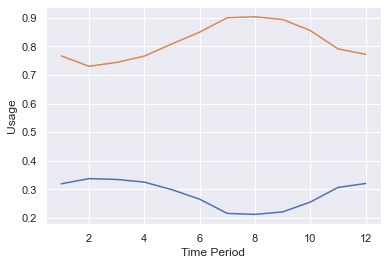

In [266]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2013', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2013', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2014

In [267]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2014']['MONTH']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2014'][_electricity_usage.file_data_years['2014']['MONTH'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2014'] = usage_count_low_lst
period_statistics['Usage Mean Low 2014'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2014'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2014'] = usage_mean_medium_lst
period_statistics['Usage Count High 2014'] = usage_count_high_lst
period_statistics['Usage Mean High 2014'] = usage_mean_high_lst

print('Medium Usage Clients (2014)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2014)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2014) {'MT_279', 'MT_196', 'MT_370'}
High Usage Client (2014) {'MT_362'}


In [268]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2014,Usage Mean Low 2014,Usage Count Medium 2014,Usage Mean Medium 2014,Usage Count High 2014,Usage Mean High 2014
0,1,366,0.007335,3,0.320947,1,0.769468
1,2,366,0.007665,3,0.336104,1,0.742770
2,3,366,0.007337,3,0.336795,1,0.745851
3,4,366,0.006643,3,0.321428,1,0.774281
4,5,366,0.006009,3,0.288790,1,0.820788
5,6,366,0.005495,3,0.261141,1,0.854984
6,7,366,0.004885,3,0.228840,1,0.889042
7,8,366,0.004530,3,0.215102,1,0.902896
8,9,366,0.005061,3,0.233525,1,0.884079
9,10,366,0.005763,3,0.257793,1,0.857089


In [269]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2014'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2014'].mean())

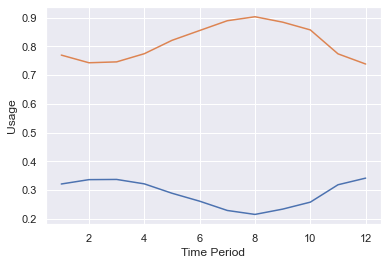

In [270]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2014', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2014', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### Year Over Year

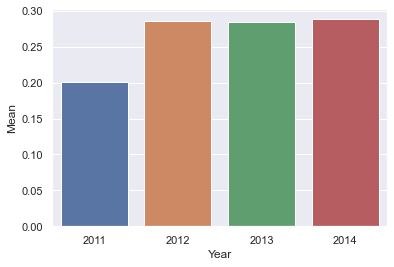

In [271]:
year_over_year_df = pd.DataFrame()
year_over_year_df['Year'] = year
year_over_year_df['Mean'] = usage_mean_medium

sns.barplot(data = year_over_year_df, x = "Year", y = "Mean")
plt.show()

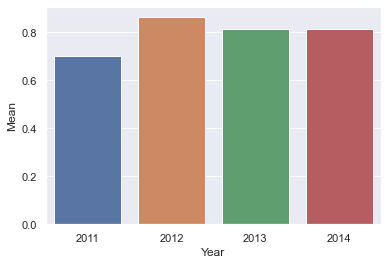

In [272]:
year_over_year_df = pd.DataFrame()
year_over_year_df['Year'] = year
year_over_year_df['Mean'] = usage_mean_high

sns.barplot(data = year_over_year_df, x = "Year", y = "Mean")
plt.show()

## Weekday

<a id='section3_2'></a>

When examining electricity usage on a weekday basis across all years, five clients were identified as falling into the medium usage cluster (MT_196, MT_208, MT_228, MT_279, MT_370), and one client was identified as falling into the high usuage cluster (MT_362).

#### 2011

Medium Usage Clients (MT_161, MT_163, MT_191, MT_194, MT_208, MT_216, MT_220, MT_228, MT_241, MT_276, MT_279, MT_323)

High Usage Client (MT_196, MT_279) 

#### 2012

Medium Usage Clients (MT_196, MT_279)

High Usage Client (MT_362)

#### 2013

Medium Usage Clients (MT_196, MT_279, MT_370)

High Usage Client (MT_362) 

#### 2014

Medium Usage Clients (MT_196, MT_279, MT_370)

High Usage Client (MT_362) 

Electricity usage appears to be fairly consistent across weekdays, with a slight increase towards the end of the week for the high usage cluster and a slight decrease towards the end of the week for the medium usage cluster.

### All Years

In [273]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data['WEEKDAY']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data[_electricity_usage.file_data['WEEKDAY'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))
    
period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst
period_statistics['Usage Count Low'] = usage_count_low_lst
period_statistics['Usage Mean Low'] = usage_mean_low_lst
period_statistics['Usage Count Medium'] = usage_count_medium_lst
period_statistics['Usage Mean Medium'] = usage_mean_medium_lst
period_statistics['Usage Count High'] = usage_count_high_lst
period_statistics['Usage Mean High'] = usage_mean_high_lst

print('Medium Usage Clients (All Years)', set(usage_summary_medium_df['Client']))
print('High Usage Client (All Years)', set(usage_summary_high_df['Client']))

Medium Usage Clients (All Years) {'MT_279', 'MT_196', 'MT_228', 'MT_370', 'MT_208'}
High Usage Client (All Years) {'MT_362'}


In [274]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low,Usage Mean Low,Usage Count Medium,Usage Mean Medium,Usage Count High,Usage Mean High
0,0,365,0.006377,4,0.253131,1,0.790562
1,1,366,0.006723,3,0.295062,1,0.787893
2,2,365,0.006353,4,0.254656,1,0.790840
3,3,365,0.006341,4,0.254916,1,0.790426
4,4,365,0.006384,4,0.257712,1,0.785624
5,5,365,0.006294,4,0.254615,1,0.787974
6,6,364,0.005887,5,0.217940,1,0.806634


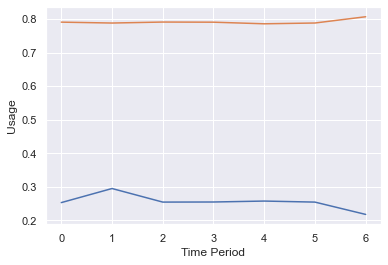

In [275]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2011

In [276]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2011']['WEEKDAY']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2011'][_electricity_usage.file_data_years['2011']['WEEKDAY'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2011'] = usage_count_low_lst
period_statistics['Usage Mean Low 2011'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2011'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2011'] = usage_mean_medium_lst
period_statistics['Usage Count High 2011'] = usage_count_high_lst
period_statistics['Usage Mean High 2011'] = usage_mean_high_lst

print('Medium Usage Clients (2011)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2011)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2011) {'MT_279', 'MT_163', 'MT_216', 'MT_228', 'MT_191', 'MT_276', 'MT_220', 'MT_194', 'MT_323', 'MT_161', 'MT_241', 'MT_208'}
High Usage Client (2011) {'MT_279', 'MT_196'}


In [277]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2011,Usage Mean Low 2011,Usage Count Medium 2011,Usage Mean Medium 2011,Usage Count High 2011,Usage Mean High 2011
0,0,366,0.006362,3,0.294294,1,0.782729
1,1,366,0.006335,3,0.293911,1,0.783694
2,2,366,0.006343,3,0.294509,1,0.783352
3,3,366,0.006335,3,0.294147,1,0.784031
4,4,366,0.006358,3,0.293871,1,0.784130
5,5,366,0.006369,3,0.295546,1,0.781233
6,6,357,0.004602,11,0.109423,2,0.611009


In [278]:
usage_mean_medium = []
usage_mean_high = []

usage_mean_medium.append(period_statistics['Usage Mean Medium 2011'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2011'].mean())

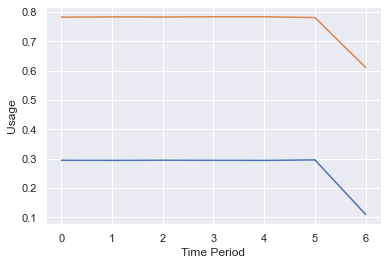

In [279]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2011', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2011', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2012

In [280]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2012']['WEEKDAY']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2012'][_electricity_usage.file_data_years['2012']['WEEKDAY'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2012'] = usage_count_low_lst
period_statistics['Usage Mean Low 2012'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2012'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2012'] = usage_mean_medium_lst
period_statistics['Usage Count High 2012'] = usage_count_high_lst
period_statistics['Usage Mean High 2012'] = usage_mean_high_lst

print('Medium Usage Clients (2012)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2012)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2012) {'MT_279', 'MT_196'}
High Usage Client (2012) {'MT_362'}


In [281]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2012,Usage Mean Low 2012,Usage Count Medium 2012,Usage Mean Medium 2012,Usage Count High 2012,Usage Mean High 2012
0,0,367,0.005720,2,0.271069,1,0.883073
1,1,367,0.005674,2,0.270395,1,0.884249
2,2,367,0.005674,2,0.268142,1,0.885265
3,3,367,0.005693,2,0.269980,1,0.883565
4,4,367,0.005806,2,0.275845,1,0.878832
5,5,367,0.005684,2,0.276826,1,0.879435
6,6,367,0.005573,2,0.264880,1,0.889098


In [282]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2012'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2012'].mean())

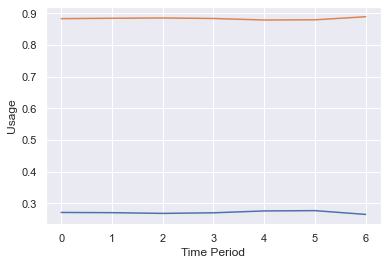

In [283]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2012', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2012', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2013

In [284]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2013']['WEEKDAY']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2013'][_electricity_usage.file_data_years['2013']['WEEKDAY'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2013'] = usage_count_low_lst
period_statistics['Usage Mean Low 2013'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2013'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2013'] = usage_mean_medium_lst
period_statistics['Usage Count High 2013'] = usage_count_high_lst
period_statistics['Usage Mean High 2013'] = usage_mean_high_lst

print('Medium Usage Clients (2013)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2013)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2013) {'MT_279', 'MT_196', 'MT_370'}
High Usage Client (2013) {'MT_362'}


In [285]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2013,Usage Mean Low 2013,Usage Count Medium 2013,Usage Mean Medium 2013,Usage Count High 2013,Usage Mean High 2013
0,0,366,0.006036,3,0.269756,1,0.840984
1,1,366,0.006005,3,0.278025,1,0.832691
2,2,366,0.005980,3,0.277202,1,0.833516
3,3,366,0.005920,3,0.277147,1,0.833795
4,4,366,0.005959,3,0.279321,1,0.831524
5,5,366,0.005948,3,0.272804,1,0.838653
6,6,366,0.005835,3,0.252771,1,0.859050


In [286]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2013'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2013'].mean())

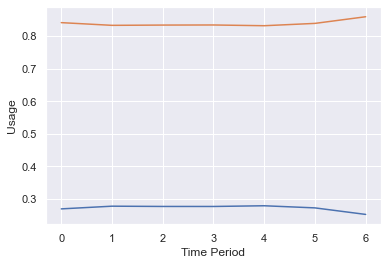

In [287]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2013', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2013', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2014

In [288]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2014']['WEEKDAY']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2014'][_electricity_usage.file_data_years['2014']['WEEKDAY'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2014'] = usage_count_low_lst
period_statistics['Usage Mean Low 2014'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2014'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2014'] = usage_mean_medium_lst
period_statistics['Usage Count High 2014'] = usage_count_high_lst
period_statistics['Usage Mean High 2014'] = usage_mean_high_lst

print('Medium Usage Clients (2014)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2014)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2014) {'MT_279', 'MT_196', 'MT_370'}
High Usage Client (2014) {'MT_362'}


In [289]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2014,Usage Mean Low 2014,Usage Count Medium 2014,Usage Mean Medium 2014,Usage Count High 2014,Usage Mean High 2014
0,0,366,0.006094,3,0.279519,1,0.831402
1,1,366,0.006082,3,0.284367,1,0.826397
2,2,366,0.006088,3,0.279638,1,0.831387
3,3,366,0.006077,3,0.279151,1,0.831531
4,4,366,0.006071,3,0.283214,1,0.827759
5,5,366,0.005930,3,0.277129,1,0.835618
6,6,366,0.005830,3,0.263173,1,0.850656


In [290]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2014'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2014'].mean())

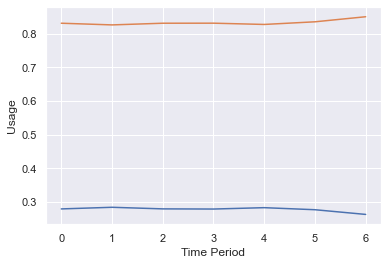

In [291]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2014', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2014', data = period_statistics)
plt.ylabel('Usage')
plt.show()

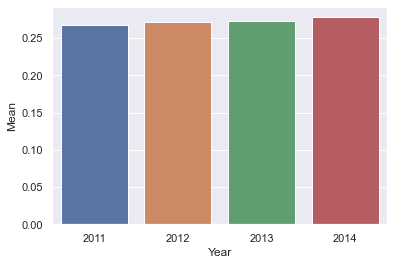

In [292]:
year_over_year_df = pd.DataFrame()
year_over_year_df['Year'] = year
year_over_year_df['Mean'] = usage_mean_medium

sns.barplot(data = year_over_year_df, x = "Year", y = "Mean")
plt.show()

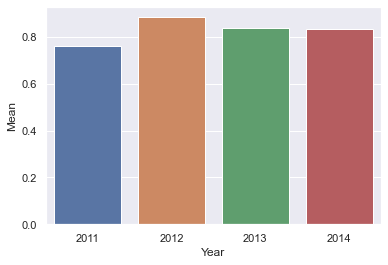

In [293]:
year_over_year_df = pd.DataFrame()
year_over_year_df['Year'] = year
year_over_year_df['Mean'] = usage_mean_high

sns.barplot(data = year_over_year_df, x = "Year", y = "Mean")
plt.show()

## Hour

<a id='section3_3'></a>

When examining electricity usage on a hourly basis across all years, twenty clients were identified as falling into the medium usage cluster (MT_102, MT_147, MT_157, MT_161, MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_362, MT_364, MT_370, MT_323), and four clients were identified as falling into the high usuage cluster (MT_196, MT_279, MT_362, MT_370).

#### 2011

Medium Usage Clients (MT_161, MT_163, MT_191, MT_194, MT_208, MT_213, MT_216, MT_218, MT_220, MT_228, MT_241, MT_276, MT_279, MT_323)

High Usage Client (MT_196, MT_279) 

#### 2012

Medium Usage Clients (MT_147, MT_157, MT_161 MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_220, MT_228, MT_241, MT_276, MT_279, MT_323, MT_339, MT_364)

High Usage Client (MT_196, MT_279, MT_362)

#### 2013

Medium Usage Clients (MT_064, MT_147, MT_152, MT_157, MT_161, MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_218, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323, MT_339, MT_345, MT_364, MT_370)

High Usage Client (MT_196, MT_279, MT_362, MT_370)

#### 2014

Medium Usage Clients (MT_064, MT_102, MT_147, MT_157, MT_161 MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_323, MT_339, MT_364, MT_370)

High Usage Client (MT_196, MT_279, MT_362, MT_370) 

Electricity usage curves for both medium and high usages clients seem to show a dropoff at around 11:00 PM and a subsequent increase at around 8:00 AM.

### All Years

In [294]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data['HOUR']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data[_electricity_usage.file_data['HOUR'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))
    
period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst
period_statistics['Usage Count Low'] = usage_count_low_lst
period_statistics['Usage Mean Low'] = usage_mean_low_lst
period_statistics['Usage Count Medium'] = usage_count_medium_lst
period_statistics['Usage Mean Medium'] = usage_mean_medium_lst
period_statistics['Usage Count High'] = usage_count_high_lst
period_statistics['Usage Mean High'] = usage_mean_high_lst

print('Medium Usage Clients (All Years)', set(usage_summary_medium_df['Client']))
print('High Usage Client (All Years)', set(usage_summary_high_df['Client']))

Medium Usage Clients (All Years) {'MT_279', 'MT_228', 'MT_191', 'MT_147', 'MT_276', 'MT_208', 'MT_163', 'MT_216', 'MT_323', 'MT_161', 'MT_196', 'MT_362', 'MT_102', 'MT_220', 'MT_224', 'MT_364', 'MT_241', 'MT_157', 'MT_194', 'MT_370'}
High Usage Client (All Years) {'MT_279', 'MT_196', 'MT_370', 'MT_362'}


In [295]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low,Usage Mean Low,Usage Count Medium,Usage Mean Medium,Usage Count High,Usage Mean High
0,0,364,0.006351,5,0.257223,1,0.749383
1,1,352,0.005529,14,0.077143,4,0.452289
2,2,355,0.005875,11,0.087840,4,0.455631
3,3,351,0.005481,15,0.077106,4,0.457621
4,4,354,0.005945,12,0.088743,4,0.456524
5,5,354,0.005845,12,0.084561,4,0.451521
6,6,352,0.005885,14,0.081142,4,0.445117
7,7,353,0.006214,13,0.088014,4,0.440340
8,8,364,0.008158,5,0.278765,1,0.691127
9,9,364,0.006913,4,0.208152,2,0.607197


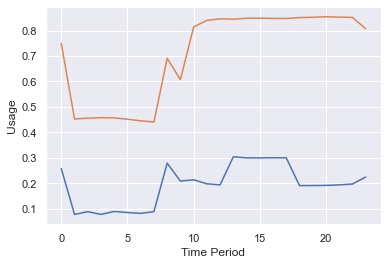

In [296]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2011

In [297]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2011']['HOUR']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2011'][_electricity_usage.file_data_years['2011']['HOUR'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2011'] = usage_count_low_lst
period_statistics['Usage Mean Low 2011'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2011'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2011'] = usage_mean_medium_lst
period_statistics['Usage Count High 2011'] = usage_count_high_lst
period_statistics['Usage Mean High 2011'] = usage_mean_high_lst

print('Medium Usage Clients (2011)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2011)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2011) {'MT_279', 'MT_163', 'MT_216', 'MT_228', 'MT_213', 'MT_191', 'MT_276', 'MT_220', 'MT_218', 'MT_194', 'MT_323', 'MT_161', 'MT_241', 'MT_208'}
High Usage Client (2011) {'MT_279', 'MT_196'}


In [298]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2011,Usage Mean Low 2011,Usage Count Medium 2011,Usage Mean Medium 2011,Usage Count High 2011,Usage Mean High 2011
0,0,359,0.004794,9,0.134439,2,0.605391
1,1,359,0.005168,9,0.134517,2,0.616145
2,2,359,0.005170,9,0.134821,2,0.615933
3,3,360,0.005289,8,0.140939,2,0.616942
4,4,358,0.004857,10,0.124364,2,0.614800
5,5,356,0.004201,12,0.101462,2,0.614897
6,6,357,0.004416,11,0.101666,2,0.632317
7,7,357,0.004514,11,0.103101,2,0.631371
8,8,366,0.006312,3,0.269631,1,0.807512
9,9,366,0.006335,3,0.285447,1,0.795958


In [299]:
usage_mean_medium = []
usage_mean_high = []

usage_mean_medium.append(period_statistics['Usage Mean Medium 2011'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2011'].mean())

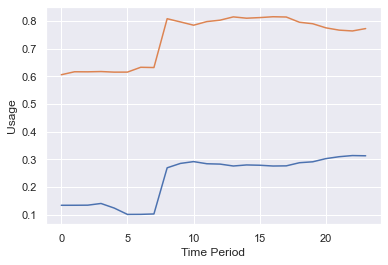

In [300]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2011', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2011', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2012

In [301]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2012']['HOUR']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2012'][_electricity_usage.file_data_years['2012']['HOUR'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2012'] = usage_count_low_lst
period_statistics['Usage Mean Low 2012'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2012'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2012'] = usage_mean_medium_lst
period_statistics['Usage Count High 2012'] = usage_count_high_lst
period_statistics['Usage Mean High 2012'] = usage_mean_high_lst

print('Medium Usage Clients (2012)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2012)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2012) {'MT_279', 'MT_196', 'MT_163', 'MT_216', 'MT_228', 'MT_191', 'MT_157', 'MT_147', 'MT_276', 'MT_220', 'MT_194', 'MT_208', 'MT_323', 'MT_364', 'MT_339', 'MT_241', 'MT_161'}
High Usage Client (2012) {'MT_279', 'MT_196', 'MT_362'}


In [302]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2012,Usage Mean Low 2012,Usage Count Medium 2012,Usage Mean Medium 2012,Usage Count High 2012,Usage Mean High 2012
0,0,365,0.005552,4,0.195423,1,0.875293
1,1,367,0.007530,2,0.338865,1,0.811049
2,2,367,0.007606,2,0.351092,1,0.796931
3,3,367,0.007703,2,0.365554,1,0.780574
4,4,359,0.006194,9,0.121110,2,0.613253
5,5,356,0.005861,12,0.102914,2,0.625590
6,6,353,0.006020,14,0.083097,3,0.519190
7,7,352,0.006087,15,0.083860,3,0.524189
8,8,352,0.006081,15,0.084974,3,0.510884
9,9,363,0.006055,5,0.138375,2,0.628134


In [303]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2012'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2012'].mean())

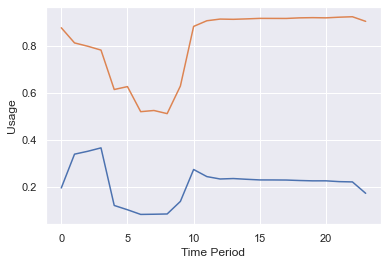

In [304]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2012', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2012', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2013

In [305]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2013']['HOUR']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2013'][_electricity_usage.file_data_years['2013']['HOUR'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2013'] = usage_count_low_lst
period_statistics['Usage Mean Low 2013'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2013'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2013'] = usage_mean_medium_lst
period_statistics['Usage Count High 2013'] = usage_count_high_lst
period_statistics['Usage Mean High 2013'] = usage_mean_high_lst

print('Medium Usage Clients (2013)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2013)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2013) {'MT_279', 'MT_228', 'MT_191', 'MT_064', 'MT_147', 'MT_276', 'MT_370', 'MT_208', 'MT_345', 'MT_163', 'MT_216', 'MT_323', 'MT_161', 'MT_196', 'MT_220', 'MT_224', 'MT_364', 'MT_241', 'MT_314', 'MT_157', 'MT_194', 'MT_339', 'MT_152', 'MT_218'}
High Usage Client (2013) {'MT_279', 'MT_196', 'MT_370', 'MT_362'}


In [306]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2013,Usage Mean Low 2013,Usage Count Medium 2013,Usage Mean Medium 2013,Usage Count High 2013,Usage Mean High 2013
0,0,366,0.005890,3,0.305685,1,0.791054
1,1,366,0.006856,2,0.295708,2,0.605313
2,2,366,0.006920,2,0.305130,2,0.601014
3,3,366,0.006977,2,0.312086,2,0.596279
4,4,362,0.006109,5,0.140541,3,0.516496
5,5,363,0.006422,4,0.150189,3,0.524123
6,6,345,0.004787,21,0.058165,4,0.459946
7,7,350,0.005678,16,0.072653,4,0.461504
8,8,350,0.005691,16,0.074899,4,0.454880
9,9,366,0.007158,3,0.336951,1,0.738075


In [307]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2013'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2013'].mean())

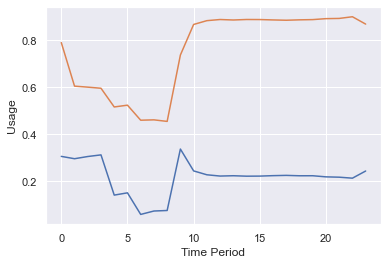

In [308]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2013', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2013', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2014

In [309]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2014']['HOUR']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2014'][_electricity_usage.file_data_years['2014']['HOUR'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2014'] = usage_count_low_lst
period_statistics['Usage Mean Low 2014'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2014'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2014'] = usage_mean_medium_lst
period_statistics['Usage Count High 2014'] = usage_count_high_lst
period_statistics['Usage Mean High 2014'] = usage_mean_high_lst

print('Medium Usage Clients (2014)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2014)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2014) {'MT_279', 'MT_228', 'MT_191', 'MT_064', 'MT_147', 'MT_276', 'MT_370', 'MT_208', 'MT_163', 'MT_216', 'MT_323', 'MT_161', 'MT_196', 'MT_102', 'MT_220', 'MT_224', 'MT_364', 'MT_241', 'MT_157', 'MT_194', 'MT_339'}
High Usage Client (2014) {'MT_279', 'MT_196', 'MT_370', 'MT_362'}


In [310]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2014,Usage Mean Low 2014,Usage Count Medium 2014,Usage Mean Medium 2014,Usage Count High 2014,Usage Mean High 2014
0,0,366,0.006705,3,0.344492,1,0.725608
1,1,366,0.007356,2,0.308244,2,0.595868
2,2,366,0.007399,2,0.327258,2,0.584018
3,3,352,0.005041,14,0.070075,4,0.456922
4,4,351,0.005068,15,0.070804,4,0.454174
5,5,360,0.006143,7,0.125324,3,0.512917
6,6,350,0.005308,16,0.069992,4,0.456548
7,7,350,0.005640,16,0.073195,4,0.460230
8,8,350,0.005676,16,0.073078,4,0.456335
9,9,366,0.006927,3,0.330191,1,0.755926


In [311]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2014'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2014'].mean())

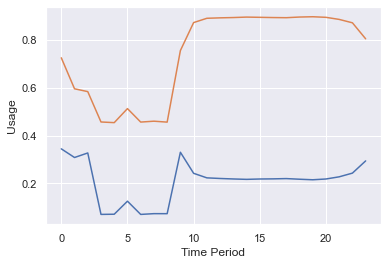

In [312]:
sns.lineplot(x = 'Time Period', y = 'Usage Mean Medium 2014', data = period_statistics)
sns.lineplot(x = 'Time Period', y = 'Usage Mean High 2014', data = period_statistics)
plt.ylabel('Usage')
plt.show()

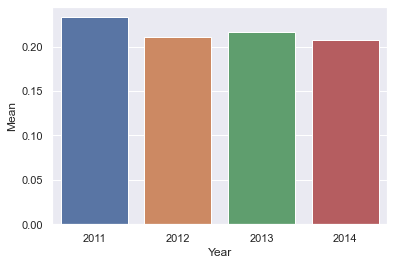

In [313]:
year_over_year_df = pd.DataFrame()
year_over_year_df['Year'] = year
year_over_year_df['Mean'] = usage_mean_medium

sns.barplot(data = year_over_year_df, x = "Year", y = "Mean")
plt.show()

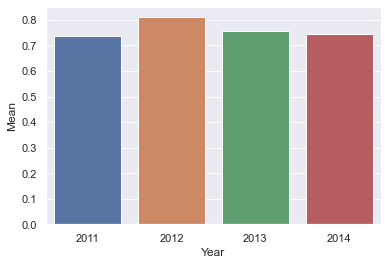

In [314]:
year_over_year_df = pd.DataFrame()
year_over_year_df['Year'] = year
year_over_year_df['Mean'] = usage_mean_high

sns.barplot(data = year_over_year_df, x = "Year", y = "Mean")
plt.show()

## Time

<a id='section3_4'></a>

When examining electricity usage on a fifteen minute interval basis across all years, five clients were identified as falling into the medium usage cluster 
(MT_064, MT_102, MT_147, MT_157, MT_161, MT_163, MT_191, MT_194, MT_196, MT_208, MT_213, MT_216, MT_218, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323, MT_339, MT_345, MT_362, MT_364, MT_370), and twenty-six clients were identified as falling into the high usuage cluster (MT_196, MT_279, MT_362, MT_370).

#### 2011

Medium Usage Clients (MT_161, MT_163, MT_166, MT_191, MT_194, MT_208, MT_213, MT_216, MT_220, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323)

High Usage Client (MT_196, MT_279)

#### 2012

Medium Usage Clients (MT_147, MT_157, MT_161 MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_220, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323, MT_339, MT_364)

High Usage Client (MT_196, MT_279, MT_362)

#### 2013

Medium Usage Clients (MT_064, MT_147, MT_152, MT_157, MT_161 MT_163, MT_166, MT_191, MT_194, MT_196, MT_208, MT_216, MT_218, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323, MT_339, MT_345, MT_364, MT_370)

High Usage Client (MT_196, MT_279, MT_362, MT_370)

#### 2014

Medium Usage Clients (MT_064, MT_102, MT_147, MT_152, MT_157, MT_161 MT_163, MT_166, MT_191, MT_194, MT_196, MT_208, MT_216, MT_218, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_323, MT_339, MT_364, MT_370)

High Usage Client (MT_196, MT_279, MT_362, MT_370)

Electricity usage curves for both medium and high usages clients seem to show a dropoff at around 11:00 PM and a subsequent increase at around 8:00 AM.

### All Years

In [315]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data['TIME']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data[_electricity_usage.file_data['TIME'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))
    
period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst
period_statistics['Usage Count Low'] = usage_count_low_lst
period_statistics['Usage Mean Low'] = usage_mean_low_lst
period_statistics['Usage Count Medium'] = usage_count_medium_lst
period_statistics['Usage Mean Medium'] = usage_mean_medium_lst
period_statistics['Usage Count High'] = usage_count_high_lst
period_statistics['Usage Mean High'] = usage_mean_high_lst

print('Medium Usage Clients (All Years)', set(usage_summary_medium_df['Client']))
print('High Usage Client (All Years)', set(usage_summary_high_df['Client']))

Medium Usage Clients (All Years) {'MT_279', 'MT_228', 'MT_191', 'MT_064', 'MT_147', 'MT_276', 'MT_370', 'MT_208', 'MT_345', 'MT_163', 'MT_216', 'MT_323', 'MT_161', 'MT_196', 'MT_362', 'MT_102', 'MT_220', 'MT_224', 'MT_364', 'MT_241', 'MT_213', 'MT_314', 'MT_157', 'MT_194', 'MT_339', 'MT_218'}
High Usage Client (All Years) {'MT_279', 'MT_196', 'MT_370', 'MT_362'}


In [316]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low,Usage Mean Low,Usage Count Medium,Usage Mean Medium,Usage Count High,Usage Mean High
63,00:00:00,364,0.005868,5,0.244399,1,0.778191
38,00:15:00,364,0.006166,5,0.251100,1,0.763542
86,00:30:00,364,0.006610,5,0.264996,1,0.732079
74,00:45:00,366,0.007638,3,0.356776,1,0.706327
43,01:00:00,350,0.005245,16,0.070486,4,0.451144
...,...,...,...,...,...,...,...
8,22:45:00,364,0.005157,5,0.201705,1,0.844762
78,23:00:00,364,0.005379,5,0.212653,1,0.827012
83,23:15:00,364,0.005479,5,0.218301,1,0.815258
69,23:30:00,364,0.005599,5,0.231410,1,0.792437


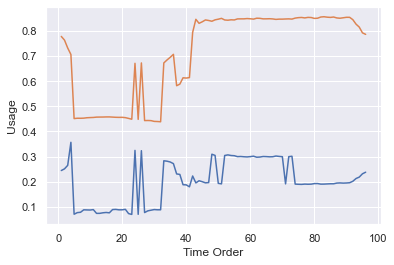

In [317]:
time_order = []

for order in range(1, (len(period_statistics) + 1)):
    time_order.append(order)
    
period_statistics['Time Order'] = time_order    

sns.lineplot(x = 'Time Order', y = 'Usage Mean Medium', data = period_statistics)
sns.lineplot(x = 'Time Order', y = 'Usage Mean High', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2011

In [318]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2011']['TIME']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2011'][_electricity_usage.file_data_years['2011']['TIME'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2011'] = usage_count_low_lst
period_statistics['Usage Mean Low 2011'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2011'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2011'] = usage_mean_medium_lst
period_statistics['Usage Count High 2011'] = usage_count_high_lst
period_statistics['Usage Mean High 2011'] = usage_mean_high_lst

print('Medium Usage Clients (2011)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2011)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2011) {'MT_279', 'MT_163', 'MT_166', 'MT_216', 'MT_213', 'MT_191', 'MT_228', 'MT_314', 'MT_276', 'MT_220', 'MT_194', 'MT_208', 'MT_323', 'MT_241', 'MT_161'}
High Usage Client (2011) {'MT_279', 'MT_196'}


In [319]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2011,Usage Mean Low 2011,Usage Count Medium 2011,Usage Mean Medium 2011,Usage Count High 2011,Usage Mean High 2011
63,00:00:00,366,0.006136,3,0.332772,1,0.741159
38,00:15:00,359,0.004920,9,0.140258,2,0.594585
86,00:30:00,361,0.005290,7,0.155015,2,0.605453
74,00:45:00,359,0.004887,9,0.128157,2,0.622598
43,01:00:00,359,0.004994,9,0.130360,2,0.620910
...,...,...,...,...,...,...,...
8,22:45:00,366,0.005872,3,0.317819,1,0.760725
78,23:00:00,366,0.005840,3,0.316549,1,0.766110
83,23:15:00,366,0.005885,3,0.308599,1,0.776894
69,23:30:00,366,0.005830,3,0.309578,1,0.776318


In [320]:
usage_mean_medium = []
usage_mean_high = []

usage_mean_medium.append(period_statistics['Usage Mean Medium 2011'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2011'].mean())

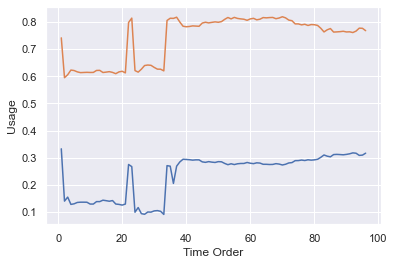

In [321]:
time_order = []

for order in range(1, (len(period_statistics) + 1)):
    time_order.append(order)
    
period_statistics['Time Order'] = time_order    

sns.lineplot(x = 'Time Order', y = 'Usage Mean Medium 2011', data = period_statistics)
sns.lineplot(x = 'Time Order', y = 'Usage Mean High 2011', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2012

In [322]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2012']['TIME']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2012'][_electricity_usage.file_data_years['2012']['TIME'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2012'] = usage_count_low_lst
period_statistics['Usage Mean Low 2012'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2012'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2012'] = usage_mean_medium_lst
period_statistics['Usage Count High 2012'] = usage_count_high_lst
period_statistics['Usage Mean High 2012'] = usage_mean_high_lst

print('Medium Usage Clients (2012)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2012)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2012) {'MT_279', 'MT_196', 'MT_163', 'MT_216', 'MT_228', 'MT_314', 'MT_191', 'MT_157', 'MT_147', 'MT_276', 'MT_220', 'MT_194', 'MT_208', 'MT_323', 'MT_364', 'MT_339', 'MT_241', 'MT_161'}
High Usage Client (2012) {'MT_279', 'MT_196', 'MT_362'}


In [323]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2012,Usage Mean Low 2012,Usage Count Medium 2012,Usage Mean Medium 2012,Usage Count High 2012,Usage Mean High 2012
63,00:00:00,365,0.005037,4,0.193547,1,0.879719
38,00:15:00,365,0.005340,4,0.188398,1,0.884629
86,00:30:00,365,0.005850,4,0.195136,1,0.875845
74,00:45:00,367,0.006758,2,0.301810,1,0.852617
43,01:00:00,367,0.007332,2,0.336243,1,0.817744
...,...,...,...,...,...,...,...
8,22:45:00,367,0.004679,2,0.217913,1,0.922774
78,23:00:00,365,0.004401,4,0.162403,1,0.914667
83,23:15:00,365,0.004514,4,0.164887,1,0.909565
69,23:30:00,365,0.004827,4,0.180882,1,0.892008


In [324]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2012'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2012'].mean())

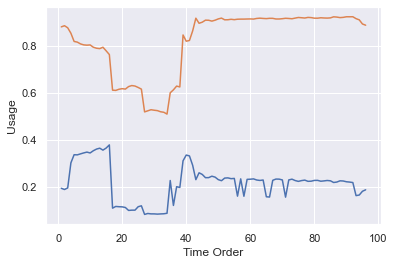

In [325]:
time_order = []

for order in range(1, (len(period_statistics) + 1)):
    time_order.append(order)
    
period_statistics['Time Order'] = time_order    

sns.lineplot(x = 'Time Order', y = 'Usage Mean Medium 2012', data = period_statistics)
sns.lineplot(x = 'Time Order', y = 'Usage Mean High 2012', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2013

In [326]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2013']['TIME']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2013'][_electricity_usage.file_data_years['2013']['TIME'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2013'] = usage_count_low_lst
period_statistics['Usage Mean Low 2013'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2013'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2013'] = usage_mean_medium_lst
period_statistics['Usage Count High 2013'] = usage_count_high_lst
period_statistics['Usage Mean High 2013'] = usage_mean_high_lst

print('Medium Usage Clients (2013)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2013)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2013) {'MT_279', 'MT_228', 'MT_191', 'MT_064', 'MT_147', 'MT_276', 'MT_370', 'MT_208', 'MT_345', 'MT_163', 'MT_216', 'MT_323', 'MT_161', 'MT_196', 'MT_220', 'MT_224', 'MT_364', 'MT_241', 'MT_166', 'MT_314', 'MT_157', 'MT_194', 'MT_339', 'MT_152', 'MT_218'}
High Usage Client (2013) {'MT_279', 'MT_196', 'MT_370', 'MT_362'}


In [327]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2013,Usage Mean Low 2013,Usage Count Medium 2013,Usage Mean Medium 2013,Usage Count High 2013,Usage Mean High 2013
63,00:00:00,366,0.005478,3,0.269510,1,0.837790
38,00:15:00,366,0.005769,3,0.301334,1,0.799242
86,00:30:00,366,0.006149,3,0.323663,1,0.761067
74,00:45:00,365,0.005918,3,0.215482,2,0.614584
43,01:00:00,365,0.006406,3,0.238294,2,0.606827
...,...,...,...,...,...,...,...
8,22:45:00,366,0.004719,3,0.207797,1,0.904842
78,23:00:00,366,0.004994,3,0.222787,1,0.890422
83,23:15:00,366,0.005077,3,0.236147,1,0.878662
69,23:30:00,367,0.005755,2,0.313195,1,0.849932


In [328]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2013'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2013'].mean())

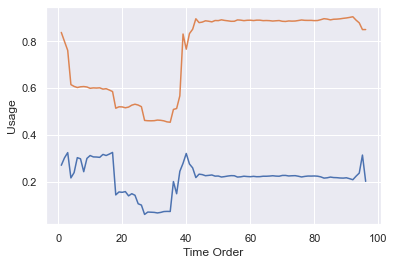

In [329]:
time_order = []

for order in range(1, (len(period_statistics) + 1)):
    time_order.append(order)
    
period_statistics['Time Order'] = time_order    

sns.lineplot(x = 'Time Order', y = 'Usage Mean Medium 2013', data = period_statistics)
sns.lineplot(x = 'Time Order', y = 'Usage Mean High 2013', data = period_statistics)
plt.ylabel('Usage')
plt.show()

### 2014

In [330]:
usage_summary_df = pd.DataFrame()

time_period_lst = []
usage_count_low_lst = []
usage_count_medium_lst = []
usage_count_high_lst = []
usage_mean_low_lst = []
usage_mean_medium_lst = []
usage_mean_high_lst = []

for time_period in set(_electricity_usage.file_data_years['2014']['TIME']):

    time_df = pd.DataFrame()
    time_df = _electricity_usage.file_data_years['2014'][_electricity_usage.file_data_years['2014']['TIME'] == time_period]

    mean_usages = []
    mean_usages.append(time_df.iloc[:, 0:370].mean())
    mean_usages = pd.DataFrame(mean_usages)

    electricity_usages = normalize([mean_usages.iloc[0].values]).reshape(-1, 1)
    model = KMeans(n_clusters = 3, random_state = 0).fit(electricity_usages)

    cluster_centers_lst = []

    count = 0

    for cluster_center in model.cluster_centers_:
        cluster_center_lst = []
    
        cluster_center_lst.append(count)
        cluster_center_lst.append(cluster_center[0])
    
        cluster_centers_lst.append(cluster_center_lst)
    
        count = count + 1    

    rank_map_df = pd.DataFrame(cluster_centers_lst, columns = ['Cluster', 'Center'])
    rank_map_df = rank_map_df.sort_values(by = ['Center'])
    rank_map_df['Rank'] = [1,2,3]    

    client_cluster_df = pd.DataFrame()
    client_cluster_df['Client'] = _electricity_usage.clients
    client_cluster_df['Cluster'] = model.labels_

    client_rank_lst = []

    for index, client_cluster in client_cluster_df.iterrows():
        client_rank_lst.append(rank_map_df[rank_map_df['Cluster'] == client_cluster[1]]['Rank'].iloc[0])

    usage_summary_period_df = pd.DataFrame()
    usage_summary_period_df['Client'] = _electricity_usage.file_data.columns[0:370]
    usage_summary_period_df['Time Period'] = time_period
    usage_summary_period_df['Usage'] = electricity_usages
    usage_summary_period_df['Rank'] = client_rank_lst
    
    usage_summary_df = pd.concat([usage_summary_df, usage_summary_period_df])
    
usage_summary_df = usage_summary_df.sort_values(by = ['Client', 'Time Period'])
usage_summary_low_df = usage_summary_df[usage_summary_df['Rank'] == 1]
usage_summary_medium_df = usage_summary_df[usage_summary_df['Rank'] == 2]
usage_summary_high_df = usage_summary_df[usage_summary_df['Rank'] == 3]

for time_period in set(usage_summary_df['Time Period']):
    time_period_lst.append(time_period)
    usage_count_low_lst.append(len(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]))
    usage_count_medium_lst.append(len(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]))
    usage_count_high_lst.append(len(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]))
    usage_mean_low_lst.append(np.mean(usage_summary_low_df[usage_summary_low_df['Time Period'] == time_period]['Usage']))
    usage_mean_medium_lst.append(np.mean(usage_summary_medium_df[usage_summary_medium_df['Time Period'] == time_period]['Usage']))
    usage_mean_high_lst.append(np.mean(usage_summary_high_df[usage_summary_high_df['Time Period'] == time_period]['Usage']))

period_statistics = pd.DataFrame()
period_statistics['Time Period'] = time_period_lst    
period_statistics['Usage Count Low 2014'] = usage_count_low_lst
period_statistics['Usage Mean Low 2014'] = usage_mean_low_lst
period_statistics['Usage Count Medium 2014'] = usage_count_medium_lst
period_statistics['Usage Mean Medium 2014'] = usage_mean_medium_lst
period_statistics['Usage Count High 2014'] = usage_count_high_lst
period_statistics['Usage Mean High 2014'] = usage_mean_high_lst

print('Medium Usage Clients (2014)', set(usage_summary_medium_df['Client']))
print('High Usage Client (2014)', set(usage_summary_high_df['Client']))


Medium Usage Clients (2014) {'MT_279', 'MT_228', 'MT_191', 'MT_064', 'MT_147', 'MT_276', 'MT_370', 'MT_208', 'MT_163', 'MT_216', 'MT_323', 'MT_161', 'MT_196', 'MT_102', 'MT_220', 'MT_224', 'MT_364', 'MT_241', 'MT_166', 'MT_157', 'MT_194', 'MT_339', 'MT_152', 'MT_218'}
High Usage Client (2014) {'MT_279', 'MT_196', 'MT_370', 'MT_362'}


In [331]:
period_statistics = period_statistics.sort_values(by = ['Time Period'])
period_statistics

,Time Period,Usage Count Low 2014,Usage Mean Low 2014,Usage Count Medium 2014,Usage Mean Medium 2014,Usage Count High 2014,Usage Mean High 2014
63,00:00:00,366,0.006478,3,0.316138,1,0.767029
38,00:15:00,366,0.006495,3,0.335103,1,0.743734
86,00:30:00,364,0.006178,4,0.209747,2,0.596961
74,00:45:00,366,0.007033,2,0.287151,2,0.606979
43,01:00:00,366,0.007265,2,0.304643,2,0.598871
...,...,...,...,...,...,...,...
8,22:45:00,366,0.005854,3,0.266428,1,0.842513
78,23:00:00,366,0.006119,3,0.279129,1,0.824069
83,23:15:00,366,0.006197,3,0.293237,1,0.807007
69,23:30:00,366,0.006007,3,0.296551,1,0.802322


In [332]:
usage_mean_medium.append(period_statistics['Usage Mean Medium 2014'].mean())
usage_mean_high.append(period_statistics['Usage Mean High 2014'].mean())

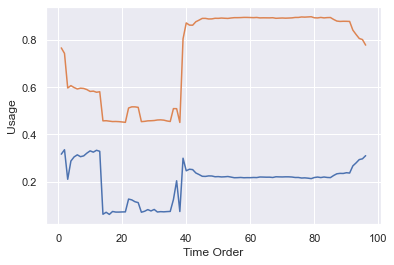

In [333]:
time_order = []

for order in range(1, (len(period_statistics) + 1)):
    time_order.append(order)
    
period_statistics['Time Order'] = time_order    

sns.lineplot(x = 'Time Order', y = 'Usage Mean Medium 2014', data = period_statistics)
sns.lineplot(x = 'Time Order', y = 'Usage Mean High 2014', data = period_statistics)
plt.ylabel('Usage')
plt.show()

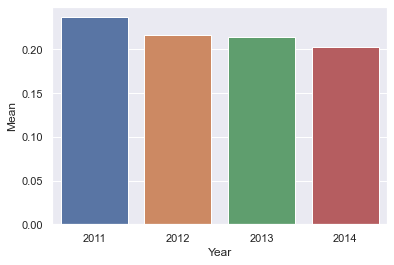

In [334]:
year_over_year_df = pd.DataFrame()
year_over_year_df['Year'] = year
year_over_year_df['Mean'] = usage_mean_medium

sns.barplot(data = year_over_year_df, x = "Year", y = "Mean")
plt.show()

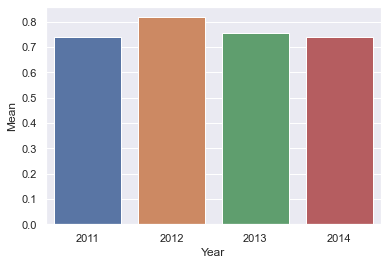

In [335]:
year_over_year_df = pd.DataFrame()
year_over_year_df['Year'] = year
year_over_year_df['Mean'] = usage_mean_high

sns.barplot(data = year_over_year_df, x = "Year", y = "Mean")
plt.show()

# Conclusions

<a id='section4'></a>

When examining electricity usage on a monthly basis across all years, five clients were identified as falling into the medium usage cluster (MT_196, MT_208, MT_228, MT_279, MT_370), and two clients were identified as falling into the high usuage cluster (MT_196, MT_362). Medium usage clients appeared to have fairly consistent usage across all months. High usage clients appreared to have a clear increase in usage between the months of April and October.

When examining electricity usage on a weekday basis across all years, five clients were identified as falling into the medium usage cluster (MT_196, MT_208, MT_228, MT_279, MT_370), and one client was identified as falling into the high usuage cluster (MT_362). Electricity usage appears to be fairly consistent across weekdays, with a slight increase towards the end of the week for the high usage cluster and a slight decrease towards the end of the week for the medium usage cluster.

When examining electricity usage on a hourly basis across all years, twenty clients were identified as falling into the medium usage cluster (MT_102, MT_147, MT_157, MT_161, MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_362, MT_364, MT_370, MT_323), and four clients were identified as falling into the high usuage cluster (MT_196, MT_279, MT_362, MT_370). Electricity usage curves for both medium and high usages clients seem to show a dropoff at around 11:00 PM and a subsequent increase at around 8:00 AM.

When examining electricity usage on a fifteen minute interval basis across all years, five clients were identified as falling into the medium usage cluster 
(MT_064, MT_102, MT_147, MT_157, MT_161, MT_163, MT_191, MT_194, MT_196, MT_208, MT_213, MT_216, MT_218, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323, MT_339, MT_345, MT_362, MT_364, MT_370), and twenty-six clients were identified as falling into the high usuage cluster (MT_196, MT_279, MT_362, MT_370). Electricity usage curves for both medium and high usages clients seem to show a dropoff at around 11:00 PM and a subsequent increase at around 8:00 AM.

#### 2011

Monthly - Medium Usage Clients (MT_220, MT_276, MT_279, MT_228, MT_208, MT_323, MT_191, MT_241, MT_194, MT_163, MT_216, MT_161). High Usage Clients (MT_196, MT_279).
Weekday - Medium Usage Clients (MT_161, MT_163, MT_191, MT_194, MT_208, MT_216, MT_220, MT_228, MT_241, MT_276, MT_279, MT_323). High Usage Client (MT_196, MT_279) 
Hourly - Medium Usage Clients (MT_161, MT_163, MT_191, MT_194, MT_208, MT_213, MT_216, MT_218, MT_220, MT_228, MT_241, MT_276, MT_279, MT_323). High Usage Client (MT_196, MT_279). 
Time - Medium Usage Clients (MT_161, MT_163, MT_166, MT_191, MT_194, MT_208, MT_213, MT_216, MT_220, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323). High Usage Client (MT_196, MT_279).
 
#### 2012

Monthly - Medium Usage Clients (MT_196, MT_279). High Usage Client (MT_362).
Weekday - Medium Usage Clients (MT_196, MT_279). High Usage Client (MT_362)
Hourly - Medium Usage Clients (MT_147, MT_157, MT_161 MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_220, MT_228, MT_241, MT_276, MT_279, MT_323, MT_339, MT_364). High Usage Client (MT_196, MT_279, MT_362).
Time - Medium Usage Clients (MT_147, MT_157, MT_161 MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_220, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323, MT_339, MT_364). High Usage Client (MT_196, MT_279, MT_362).

#### 2013

Monthly - Medium Usage Clients (MT_196, MT_279, MT_370). High Usage Client (MT_362).
Weekday - Medium Usage Clients (MT_196, MT_279, MT_370). High Usage Client (MT_362). 
Hourly - Medium Usage Clients (MT_064, MT_147, MT_152, MT_157, MT_161, MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_218, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323, MT_339, MT_345, MT_364, MT_370). High Usage Client (MT_196, MT_279, MT_362, MT_370)
Time - Medium Usage Clients (MT_064, MT_147, MT_152, MT_157, MT_161 MT_163, MT_166, MT_191, MT_194, MT_196, MT_208, MT_216, MT_218, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_314, MT_323, MT_339, MT_345, MT_364, MT_370). High Usage Client (MT_196, MT_279, MT_362, MT_370).

#### 2014

Monthly - Medium Usage Clients (MT_196, MT_279, MT_370). High Usage Client (MT_362).
Weekday - Medium Usage Clients (MT_196, MT_279, MT_370). High Usage Client (MT_362). 
Hourly - Medium Usage Clients (MT_064, MT_102, MT_147, MT_157, MT_161 MT_163, MT_191, MT_194, MT_196, MT_208, MT_216, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_323, MT_339, MT_364, MT_370). High Usage Client (MT_196, MT_279, MT_362, MT_370).
Time - Medium Usage Clients (MT_064, MT_102, MT_147, MT_152, MT_157, MT_161 MT_163, MT_166, MT_191, MT_194, MT_196, MT_208, MT_216, MT_218, MT_220, MT_224, MT_228, MT_241, MT_276, MT_279, MT_323, MT_339, MT_364, MT_370)/ High Usage Client (MT_196, MT_279, MT_362, MT_370).